# Experiments with dynamic scaling and CNNs

_22 August 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

These are the first experiments after the fix in [`81b0ac3`](https://github.com/czlee/jadeite/commit/81b0ac354c4edfc7ea41ce00c64fc1cdffdb8c19). The plots before the fix are in [the version of this file from commit `17a3fb7`](https://github.com/czlee/kyanite/blob/17a3fb75b9e23323e4fb03c491dc34160de3fc4b/dynamic-cnns.ipynb) of this repository.

In [1]:
import matplotlib.pyplot as plt
from plotting import plot_averaged_training_charts, plot_comparison, make_axes, show_timestamp_info

# Fashion-MNIST

In [2]:
paths = ["results/20210822-fmnist-dynamic"]
show_timestamp_info(paths)

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **22 Aug 2021, 01:19:11** | 22 Aug 2021, 01:48:52 | 29 min 41 s |
| last to finish | 22 Aug 2021, 04:20:37 | **22 Aug 2021, 04:53:01** | 32 min 24 s |
| shortest | 22 Aug 2021, 01:19:11 | 22 Aug 2021, 01:48:44 | **29 min 33 s** |
| longest | 22 Aug 2021, 02:24:11 | 22 Aug 2021, 03:03:01 | **38 min 49 s** |


In [3]:
def get_comparison_specs(noise='__all__'):
    common_specs = {
        'rounds':                 ('expect', 150),
        'batch_size':             ('expect', 64),
        'epochs':                 ('expect', 1),
        'ema_coefficient':        ('expect', 1 / 3),
        'data_per_client':        ('expect', None),
        'save_squared_error':     ('expect', False),
        'send':                   ('expect', 'deltas'),
        'power':                  ('title',  1.0),
        'dataset':                ('title',  'fashionmnist-cnn2'),
        'lr_client':              ('title',  0.001),
        'momentum_client':        ('expect', 0.0),
        'weight_decay_client':    ('expect', 0.0),
        'optimizer_client':       ('expect', 'sgd'),
        'clients':                ('title',  20),
        'noise':                  ('series', noise),
        'lr_scheduler_client':    ('title',  'multistep-100-0.1'),
    }
    analog_specs = common_specs.copy()
    analog_specs.update({
        'script': 'dynpower.py',
        'power_update_period':    ('expect', 1),
        'power_quantile':         ('expect', 0.9),
        'power_factor':           ('expect', 0.9),
    })
    digital_specs = common_specs.copy()
    digital_specs.update({
        'script': 'dynquant.py',
        'qrange_update_period':   ('expect', 1),
        'qrange_param_quantile':  ('expect', 0.9),
        'qrange_client_quantile': ('expect', 0.9),
        'channel_uses':           ('expect', None),
        'rounding_method':        ('expect', 'stochastic'),
        'parameter_schedule':     ('expect', 'staggered'),
        'zero_bits_strategy':     ('expect', 'read-zero'),
    })
    
    return analog_specs, digital_specs

def _plot_comparisons(field, paths, all_specs, zoom_ylim=None, axsize=(11, 7), **kwargs):
    axs = make_axes(2 if zoom_ylim else 1, axsize=axsize)
    kwargs.setdefault('extra_lines', ['confints'])
    plot_comparison(field, paths, *all_specs, ax=axs[0], **kwargs)
    if zoom_ylim:
        plot_comparison(field, paths, *all_specs, ax=axs[1], quiet=True, **kwargs)
        axs[1].set_ylim(zoom_ylim)

def plot_analog_vs_digital(paths, noise='__all__', field='accuracy', zoom_ylim=None, **kwargs):
    all_specs = get_comparison_specs(noise)
    _plot_comparisons(field, paths, all_specs, zoom_ylim=zoom_ylim, **kwargs)

- Skipping 3 runs that don't match on 1 keys: noise (3)
- Skipping 3 runs that don't match on 1 keys: noise (3)


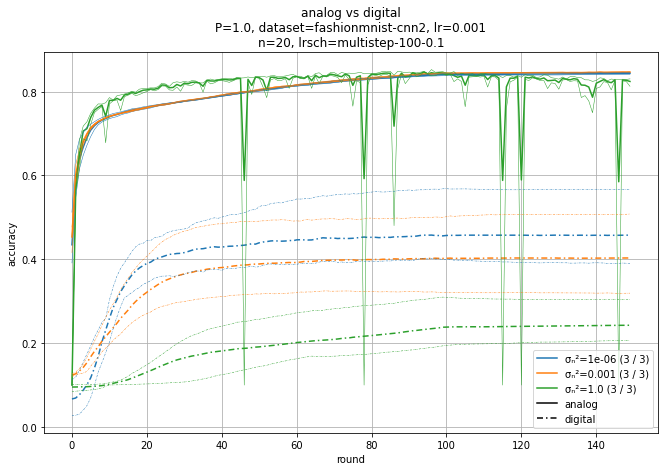

In [4]:
plot_analog_vs_digital(paths, noise=[1e-6, 1e-3, 1], extra_lines=['range'])

- Skipping 9 runs that don't match on 1 keys: noise (9)
- Skipping 9 runs that don't match on 1 keys: noise (9)


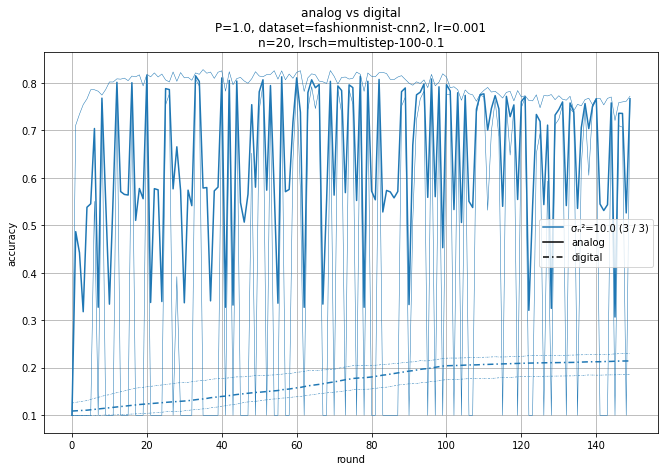

In [5]:
plot_analog_vs_digital(paths, noise=[10], extra_lines=['range'])

Okay, this looks much better. Also, seems like the LR change at 100 might not be so helpful. And we probably don't need to look so hard at $\sigma_\mathrm{n}^2 = 10.0$; instead, going the other way, with higher SNRs, may be more insightful.

# Fashion-MNIST with plain federated averaging

With all data always used, divided among the clients:

- Skipping 4 runs that don't match on 3 keys: data_per_client (4), lr_client (4), lr_scheduler_client (4)


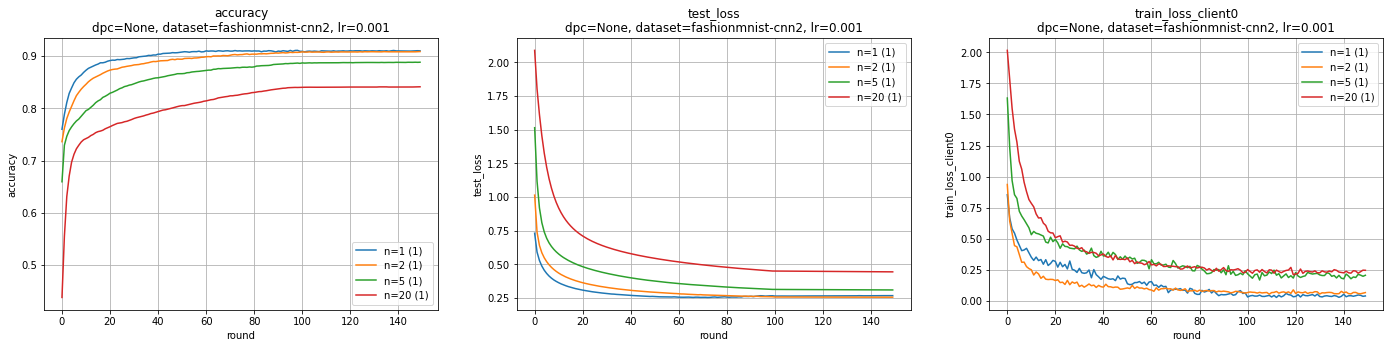

In [6]:
paths = ["results/20210822-fmnist-fedavg"]
specs = {
    'script': 'fedavg.py',
    'rounds':                 ('expect', 150),
    'batch_size':             ('expect', 64),
    'epochs':                 ('expect', 1),
    'data_per_client':        ('title',  None),
    'save_squared_error':     ('expect', False),
    'send':                   ('expect', 'deltas'),
    'dataset':                ('title',  'fashionmnist-cnn2'),
    'lr_client':              ('title',  0.001),
    'momentum_client':        ('expect', 0.0),
    'weight_decay_client':    ('expect', 0.0),
    'optimizer_client':       ('expect', 'sgd'),
    'clients':                ('series', '__all__'),
    'lr_scheduler_client':    ('filter', 'multistep-100-0.1'),
}
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs)

- Skipping 4 runs that don't match on 3 keys: data_per_client (4), lr_client (4), lr_scheduler_client (4)


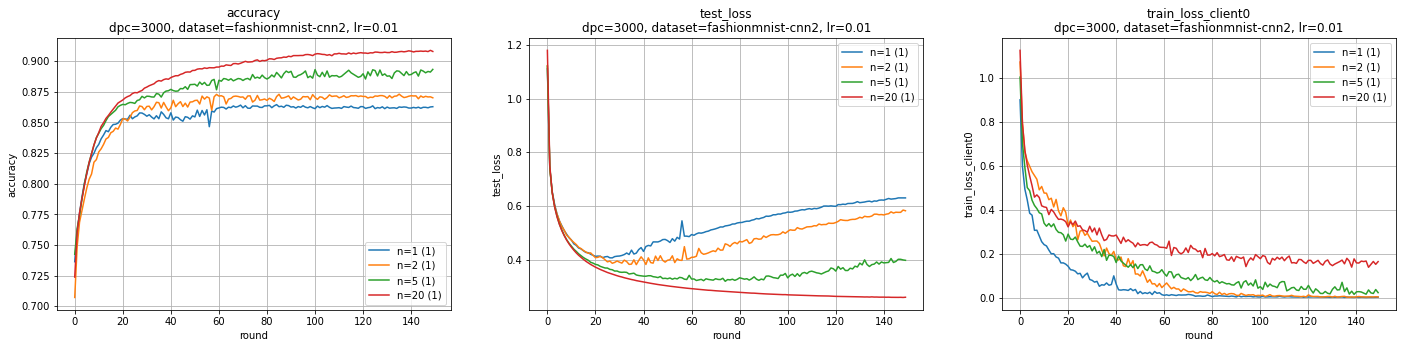

In [7]:
paths = ["results/20210822-fmnist-fedavg"]
specs = {
    'script': 'fedavg.py',
    'rounds':                 ('expect', 150),
    'batch_size':             ('expect', 64),
    'epochs':                 ('expect', 1),
    'data_per_client':        ('title',  3000),
    'save_squared_error':     ('expect', False),
    'send':                   ('expect', 'deltas'),
    'dataset':                ('title',  'fashionmnist-cnn2'),
    'lr_client':              ('title',  0.01),
    'momentum_client':        ('expect', 0.0),
    'weight_decay_client':    ('expect', 0.0),
    'optimizer_client':       ('expect', 'sgd'),
    'clients':                ('series', '__all__'),
    'lr_scheduler_client':    ('filter', 'none'),
}
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs)

## Different learning rates

What learning rate should we use?

- Skipping 20 runs that don't match on 2 keys: lr_client (20), weight_decay_client (5)


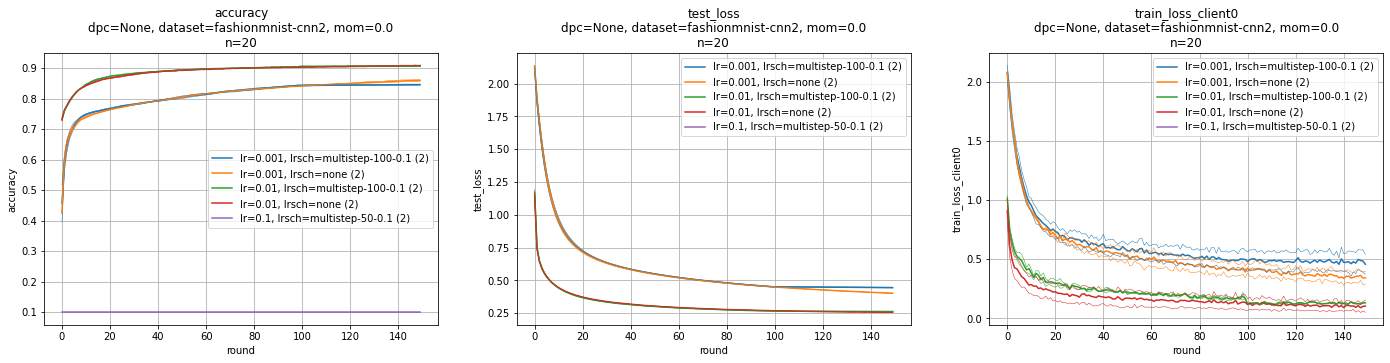

In [8]:
paths = ["results/20210822-fmnist-fedavg-trials"]
specs = {
    'script': 'fedavg.py',
    'rounds':                 ('expect', 150),
    'batch_size':             ('expect', 64),
    'epochs':                 ('expect', 1),
    'data_per_client':        ('title',  None),
    'save_squared_error':     ('expect', False),
    'send':                   ('expect', 'deltas'),
    'dataset':                ('title',  'fashionmnist-cnn2'),
    'lr_client':              ('series', [0.1, 0.01, 0.001]),
    'momentum_client':        ('title',  0.0),
    'weight_decay_client':    ('filter', 0.0),
    'optimizer_client':       ('expect', 'sgd'),
    'clients':                ('title',  20),
    'lr_scheduler_client':    ('series', '__all__'),
}
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs, extra_lines=['range'])

0.01 is unambiguously better, it seems. But 0.1 goes too far and ends up doing nothing; the test loss is actually `nan` a lot of the time.

- Skipping 6 runs that don't match on 1 keys: lr_client (6)


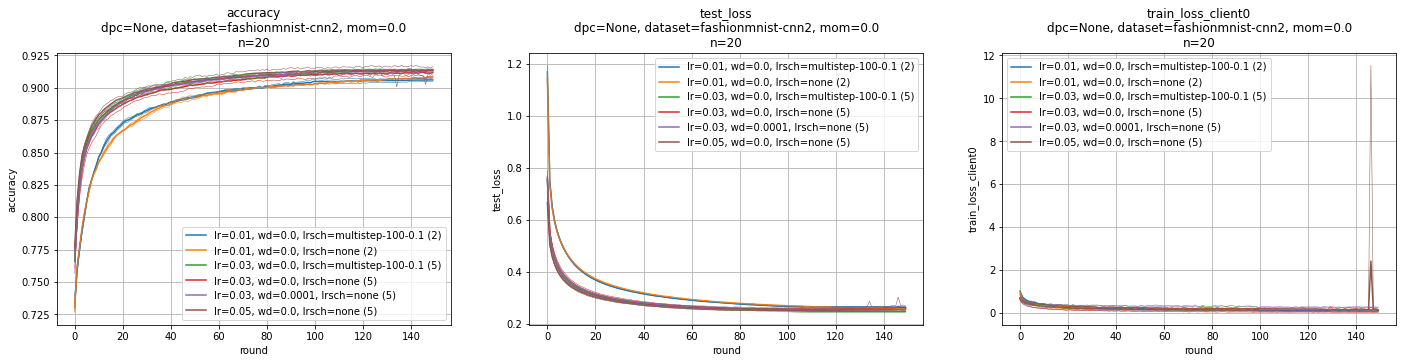

In [9]:
paths = ["results/20210822-fmnist-fedavg-trials"]
specs = {
    'script': 'fedavg.py',
    'rounds':                 ('expect', 150),
    'batch_size':             ('expect', 64),
    'epochs':                 ('expect', 1),
    'data_per_client':        ('title',  None),
    'save_squared_error':     ('expect', False),
    'send':                   ('expect', 'deltas'),
    'dataset':                ('title',  'fashionmnist-cnn2'),
    'lr_client':              ('series', [0.01, 0.03, 0.05]),
    'momentum_client':        ('title',  0.0),
    'weight_decay_client':    ('series', '__all__'),
    'optimizer_client':       ('expect', 'sgd'),
    'clients':                ('title',  20),
    'lr_scheduler_client':    ('series', '__all__'),
}
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs, extra_lines=['range'])

- Skipping 6 runs that don't match on 1 keys: lr_client (6)


(0.0, 0.4)

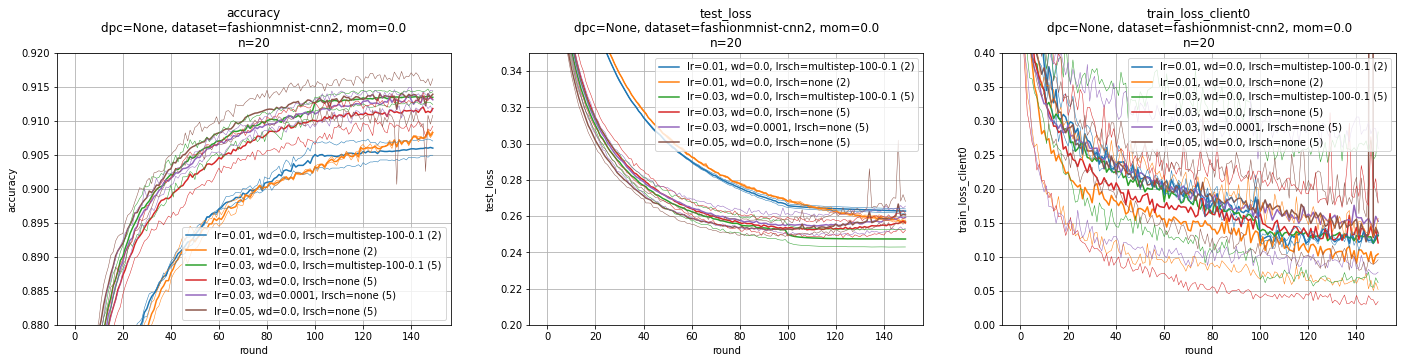

In [10]:
axs = make_axes(3)
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs, axs=axs, extra_lines=['range'])
axs[0].set_ylim((0.88, 0.92))
axs[1].set_ylim((0.2, 0.35))
axs[2].set_ylim((0, 0.4))

# CIFAR-10

In [11]:
paths = ["results/20210822-cifar-dynamic/"]
show_timestamp_info(paths)

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **22 Aug 2021, 01:19:54** | 22 Aug 2021, 02:28:56 | 1 h 09 min 01 s |
| last to finish | 22 Aug 2021, 03:50:05 | **22 Aug 2021, 04:53:06** | 1 h 03 min 01 s |
| shortest | 22 Aug 2021, 03:50:05 | 22 Aug 2021, 04:53:06 | **1 h 03 min 01 s** |
| longest | 22 Aug 2021, 01:19:54 | 22 Aug 2021, 02:28:56 | **1 h 09 min 01 s** |


In [12]:
def get_comparison_specs(noise='__all__'):
    common_specs = {
        'rounds':                 ('expect', 150),
        'batch_size':             ('title', 128),
        'epochs':                 ('expect', 1),
        'ema_coefficient':        ('expect', 1 / 3),
        'data_per_client':        ('expect', None),
        'save_squared_error':     ('expect', False),
        'send':                   ('expect', 'deltas'),
        'power':                  ('title',  1.0),
        'dataset':                ('title',  'cifar10-resnet20-flipcrop'),
        'lr_client':              ('title',  0.1),
        'momentum_client':        ('title',  0.9),
        'weight_decay_client':    ('title',  1e-4),
        'optimizer_client':       ('expect', 'sgd'),
        'clients':                ('title',  20),
        'noise':                  ('series', noise),
        'lr_scheduler_client':    ('expect', 'multistep-100-0.1'),
    }
    analog_specs = common_specs.copy()
    analog_specs.update({
        'script': 'dynpower.py',
        'power_update_period':    ('expect', 1),
        'power_quantile':         ('expect', 0.9),
        'power_factor':           ('expect', 0.9),
    })
    digital_specs = common_specs.copy()
    digital_specs.update({
        'script': 'dynquant.py',
        'qrange_update_period':   ('expect', 1),
        'qrange_param_quantile':  ('expect', 0.9),
        'qrange_client_quantile': ('expect', 0.9),
        'channel_uses':           ('expect', None),
        'rounding_method':        ('expect', 'stochastic'),
        'parameter_schedule':     ('expect', 'staggered'),
        'zero_bits_strategy':     ('expect', 'read-zero'),
    })
    
    return analog_specs, digital_specs

Digital doesn't even get off the ground. Also, that LR change at the 100th round might be counterproductive here.

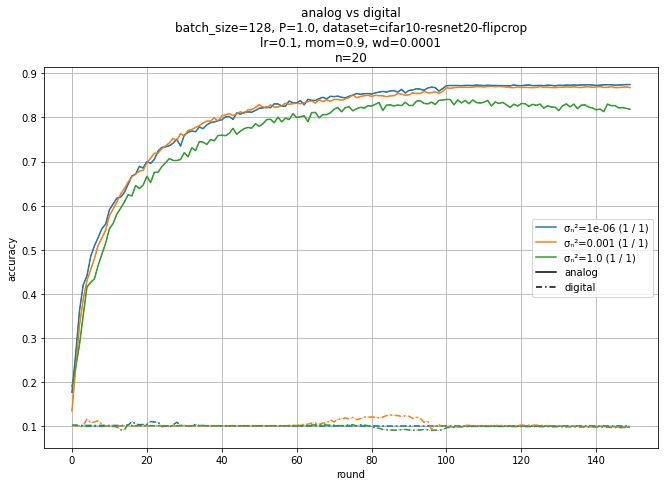

In [13]:
plot_analog_vs_digital(paths, noise=[1e-6, 1e-3, 1, 10], extra_lines=['range'])

Why is digital doing so miserably? Is its training loss actually going down less quickly?

- Skipping 3 runs using 1 other scripts: dynpower.py (3)


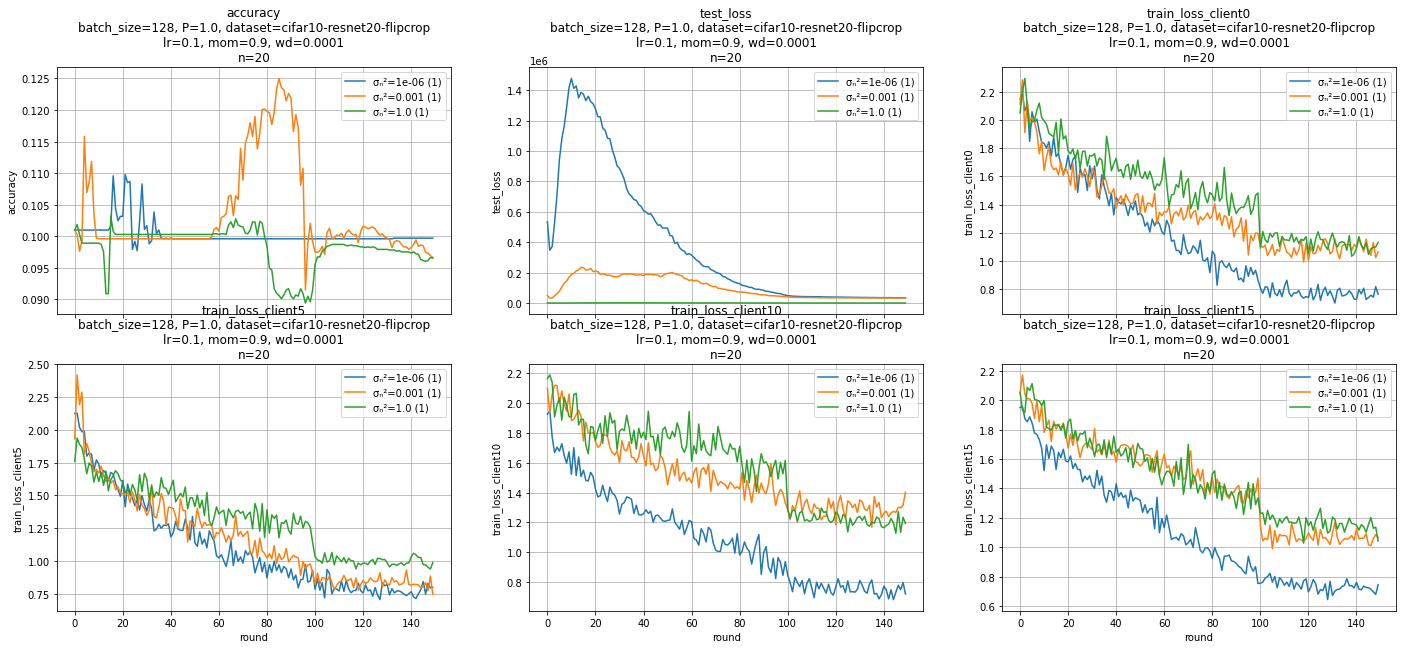

In [14]:
analog_specs, digital_specs = get_comparison_specs()
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0', 'train_loss_client5', 
                                      'train_loss_client10', 'train_loss_client15'], digital_specs)

- Skipping 3 runs using 1 other scripts: dynquant.py (3)


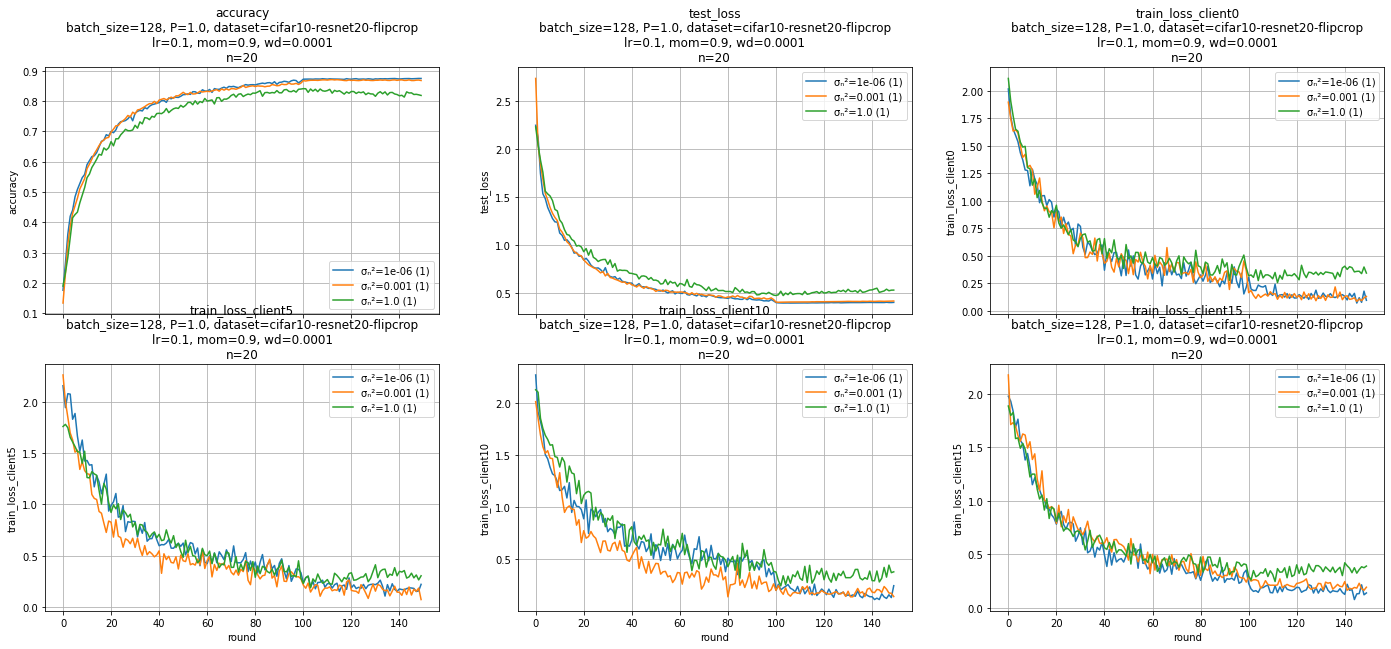

In [15]:
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0', 'train_loss_client5', 
                                      'train_loss_client10', 'train_loss_client15'], analog_specs)

Yes. We should try this with very high SNRs to be sure it is actually the communication constraint getting in the way.

## Digital with very high SNRs

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **22 Aug 2021, 01:19:54** | 22 Aug 2021, 02:28:56 | 1 h 09 min 01 s |
| last to finish | 22 Aug 2021, 07:52:45 | **22 Aug 2021, 09:15:31** | 1 h 22 min 46 s |
| shortest | 22 Aug 2021, 03:50:05 | 22 Aug 2021, 04:53:06 | **1 h 03 min 01 s** |
| longest | 22 Aug 2021, 06:26:22 | 22 Aug 2021, 07:52:45 | **1 h 26 min 23 s** |


- Skipping 3 runs using 1 other scripts: dynpower.py (3)


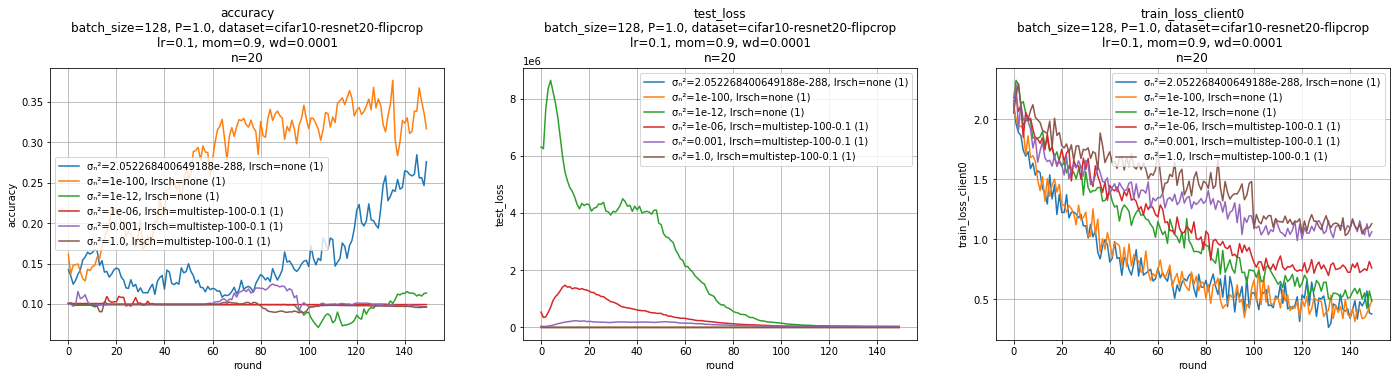

In [16]:
paths = ["results/20210822-cifar-dynamic", "results/20210822-cifar-dynamic-highsnr/"]
show_timestamp_info(paths)

specs = {
    'script': 'dynquant.py',
    'rounds':                 ('expect', 150),
    'batch_size':             ('title', 128),
    'epochs':                 ('expect', 1),
    'ema_coefficient':        ('expect', 1 / 3),
    'data_per_client':        ('expect', None),
    'save_squared_error':     ('expect', False),
    'send':                   ('expect', 'deltas'),
    'power':                  ('title',  1.0),
    'dataset':                ('title',  'cifar10-resnet20-flipcrop'),
    'lr_client':              ('title',  0.1),
    'momentum_client':        ('title',  0.9),
    'weight_decay_client':    ('title',  1e-4),
    'optimizer_client':       ('expect', 'sgd'),
    'clients':                ('title',  20),
    'noise':                  ('series', '__all__'),
    'lr_scheduler_client':    ('series', '__all__'),
    'qrange_update_period':   ('expect', 1),
    'qrange_param_quantile':  ('expect', 0.9),
    'qrange_client_quantile': ('expect', 0.9),
    'channel_uses':           ('expect', None),
    'rounding_method':        ('expect', 'stochastic'),
    'parameter_schedule':     ('expect', 'staggered'),
    'zero_bits_strategy':     ('expect', 'read-zero'),
}

plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs)

# CIFAR-10 with plain federated averaging

In [17]:
paths = ["results/20210822-cifar-fedavg/"]
show_timestamp_info(paths)

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **22 Aug 2021, 01:19:54** | 22 Aug 2021, 02:24:44 | 1 h 04 min 49 s |
| last to finish | 22 Aug 2021, 04:31:42 | **22 Aug 2021, 05:39:03** | 1 h 07 min 20 s |
| shortest | 22 Aug 2021, 01:19:54 | 22 Aug 2021, 01:30:14 | **10 min 19 s** |
| longest | 22 Aug 2021, 02:05:50 | 22 Aug 2021, 03:14:19 | **1 h 08 min 29 s** |


In [18]:
specs = {
    'script': 'fedavg.py',
    'rounds':                 ('expect', 150),
    'batch_size':             ('expect', 128),
    'epochs':                 ('expect', 1),
    'data_per_client':        ('title',  None),
    'save_squared_error':     ('expect', False),
    'send':                   ('expect', 'deltas'),
    'dataset':                ('title',  'cifar10-resnet20-flipcrop'),
    'lr_client':              ('expect', 0.1),
    'momentum_client':        ('expect', 0.9),
    'weight_decay_client':    ('expect', 1e-4),
    'optimizer_client':       ('expect', 'sgd'),
    'clients':                ('series', '__all__'),
    'lr_scheduler_client':    ('expect', 'multistep-100-0.1'),
}

- Skipping 4 runs that don't match on 1 keys: data_per_client (4)


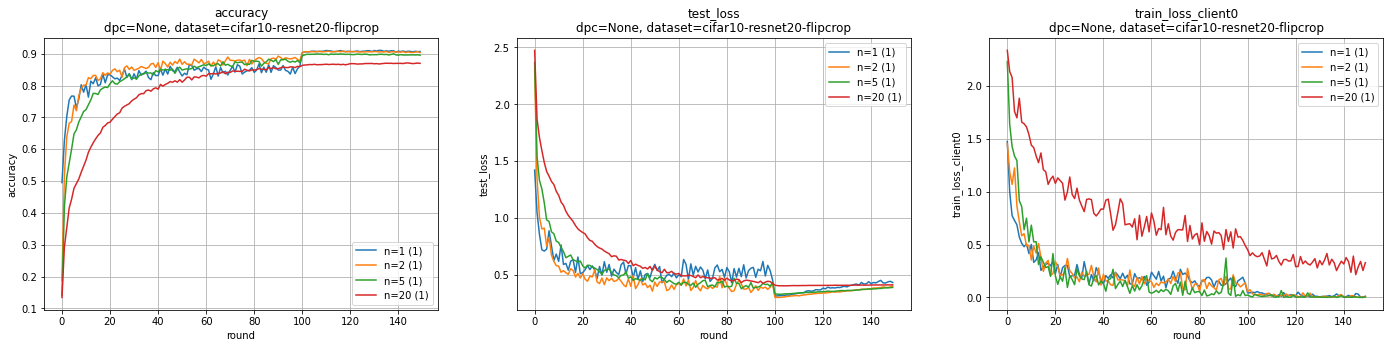

In [19]:
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs)

- Skipping 4 runs that don't match on 1 keys: data_per_client (4)


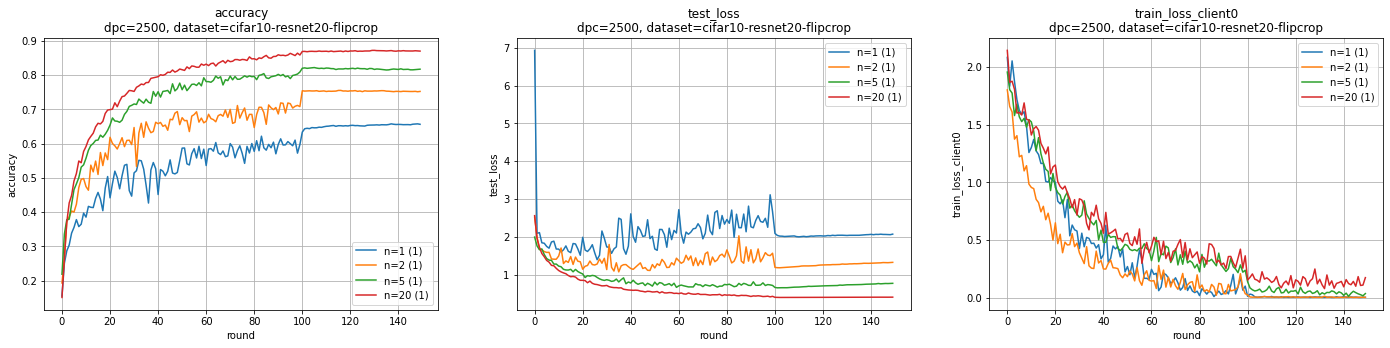

In [20]:
specs['data_per_client'] = ('title', 2500)
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs)

## Different learning rates

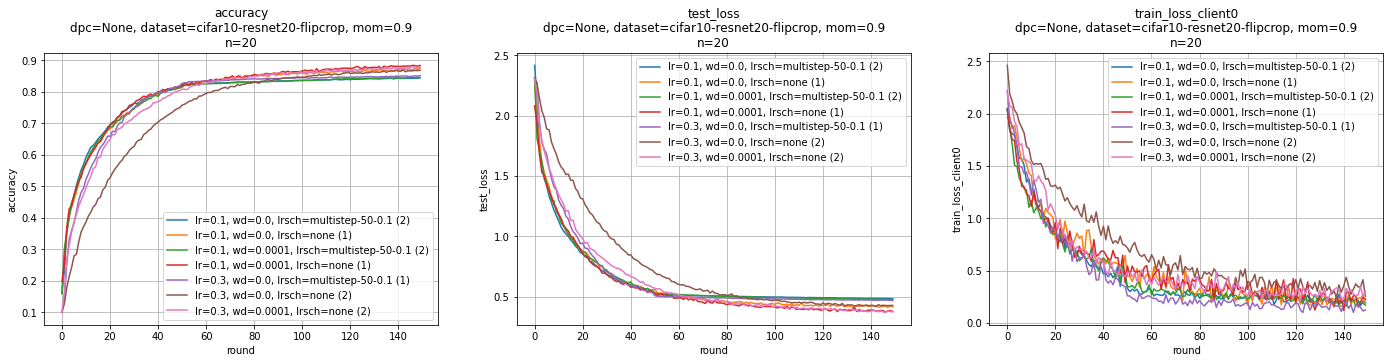

In [21]:
paths = ["results/20210822-cifar-fedavg-trials"]
specs = {
    'script': 'fedavg.py',
    'rounds':                 ('expect', 150),
    'batch_size':             ('expect', 128),
    'epochs':                 ('expect', 1),
    'data_per_client':        ('title',  None),
    'save_squared_error':     ('expect', False),
    'send':                   ('expect', 'deltas'),
    'dataset':                ('title',  'cifar10-resnet20-flipcrop'),
    'lr_client':              ('series', '__all__'),
    'momentum_client':        ('title',  0.9),
    'weight_decay_client':    ('series', '__all__'),
    'optimizer_client':       ('expect', 'sgd'),
    'clients':                ('title',  20),
    'lr_scheduler_client':    ('series', '__all__'),
}
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs)

(0.0, 0.5)

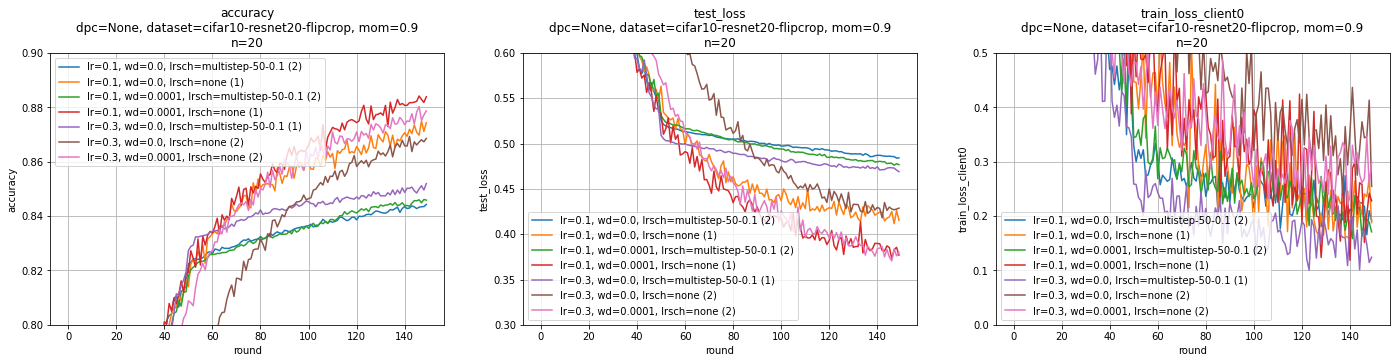

In [22]:
axs = make_axes(3)
plot_averaged_training_charts(paths, ['accuracy', 'test_loss', 'train_loss_client0'], specs, axs=axs)
axs[0].set_ylim((0.8, 0.9))
axs[1].set_ylim((0.3, 0.6))
axs[2].set_ylim((0.0, 0.5))